<a id="TOP"> </a>
<div class="alert alert-block alert-info">
</div>

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wrangle_mvp import clean_zillow
from wrangle_mvp import boxplots, hists, split_data_continuous, model_sets
import seaborn as sns


In [2]:
df = clean_zillow()

Number of observations removed: 5516


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35848 entries, 1 to 52278
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds       35848 non-null  float64
 1   baths      35848 non-null  float64
 2   area       35848 non-null  float64
 3   tax_value  35848 non-null  float64
dtypes: float64(4)
memory usage: 1.4 MB


In [4]:
train, validate, test = split_data_continuous(df, with_baseline=True)

Prepared df: (35848, 4)

Train: (21508, 4)
Validate: (7170, 4)
Test: (7170, 4)
The mean_preds had the lowest RMSE: 215859 with an in/out of: 0.999


In [32]:
X_train, y_train, X_validate, y_validate, X_test, y_test = model_sets(train, validate, test)


X_cols = ['beds', 'baths', 'area']

y_cols = ['tax_value', 'baseline']




## Prepare Data for Modeling

**Wrangle**

1. Acquired data from zillow RDBMS. 

2. Clean data

3. Split data 

4. Scale data

`wrangel_mvp.clean_zillow`, `.split_data_continuous`, and `.model_sets` returns the following: 

| Object Returned | Description | Purpose                          |
|:-------------------|:--------------------------------|:----------------------------------------------------|
| 1. df | **Dataframe**, **Feature** and **target** variables, **Unscaled** | New features, additional cleaning needed, etc. |
| 2. X_train | **Dataframe**, **Feature** variables only, **Scaled**| Feature selection, fit models, make predictions |
| 3. y_train | **Series**, **Target** variable and baseline only, **Unscaled** | Feature selection, evaluate model predictions |
| 4. X_validate | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using top models |
| 5. y_validate | **Series**, **Target** variable and baseline only, **Unscaled** | Evaluate model predictions made from X_validate to assess overfitting | 
| 6. X_test | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using best model|
| 7. y_test | **Series**, **Target** variable and baseline only, **Unscaled** | Evaluate model predictions made from X_test to estimate future performance on new data |

<a id="imports"> </a>

In [70]:
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

In [30]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21508 entries, 30326 to 49470
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tax_value  21508 non-null  float64
 1   baseline   21508 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1020.1 KB


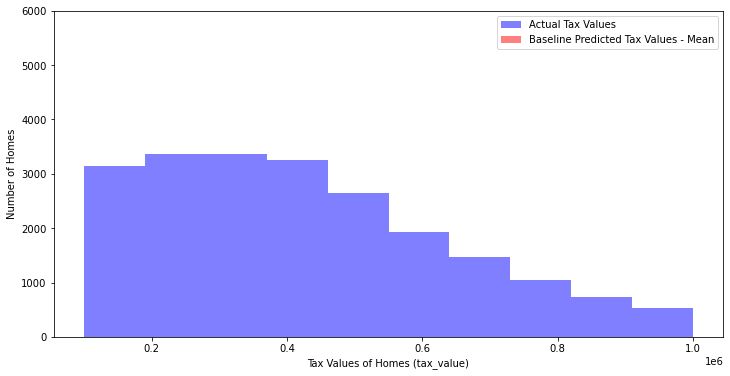

In [29]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(12,6))

plt.hist(y_train.tax_value, 
         color='blue', 
         alpha=.5, 
         label="Actual Tax Values"
        )
plt.hist(y_train.baseline, 
         bins=1, 
         color='red', 
         alpha=.5, 
#          rwidth=1, 
         label="Baseline Predicted Tax Values - Mean"
        )
plt.xlabel("Tax Values of Homes (tax_value)")
plt.ylabel("Number of Homes")

plt.ylim(0, 6_000)

plt.legend()
plt.show()

In [11]:
del rwidth

NameError: name 'rwidth' is not defined

In [55]:
# create the model objects:

lm = LinearRegression(normalize=True)

lars = LassoLars(alpha=1, random_state=123)

glm = TweedieRegressor(power=(1), alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the things
# 
lm.fit(X_train, y_train.tax_value)

lars.fit(X_train, y_train.tax_value)

glm.fit(X_train, y_train.tax_value)

# predict trains

y_train['value_pred_lm'] = lm.predict(X_train)

y_train['value_pred_lars'] = lars.predict(X_train)

y_train['value_pred_glm'] = glm.predict(X_train)

# set up y_train without target, and baseline
y_trained = y_train.drop(columns=['tax_value', 'baseline'])

# make a list of the models for predicting
models = [lm.predict, lars.predict, glm.predict]

# names of the models for displaying
model_names = ['LinearRegression', 'LassoLars', 'TweedieRegressor']

# for loop to get the RMSE of each of the models and print them
for i in y_trained:
    for n in range(0,len(y_trained.columns)):
        if i == y_trained.columns[n]:
            j = models[n]
            k = model_names[n]
            # evaluate: rmse
            rmse_train = mean_squared_error(y_train.tax_value, y_trained[i]) ** (1/2)

            # predict validate
            y_validate[i] = j(X_validate)

            # evaluate: rmse
            rmse_validate = mean_squared_error(y_validate.tax_value, y_validate[i]) ** (1/2)

            print(f"\nRMSE {i} using {k}\n--------\nTraining/In-Sample: ", rmse_train, 
                  "\n---------\nValidation/Out-of-Sample: ", rmse_validate,"\n")
    continue


RMSE value_pred_lm using LinearRegression
--------
Training/In-Sample:  197972.41031438438 
---------
Validation/Out-of-Sample:  200403.27832457158 


RMSE value_pred_lars using LassoLars
--------
Training/In-Sample:  197972.6808731498 
---------
Validation/Out-of-Sample:  200398.11655464413 


RMSE value_pred_glm using TweedieRegressor
--------
Training/In-Sample:  198041.36751348778 
---------
Validation/Out-of-Sample:  200481.7408834824 



In [59]:
# create the model objects:

lm = LinearRegression(normalize=True)

lars = LassoLars(alpha=1, random_state=123)

glm = TweedieRegressor(power=(1), alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the things
# 
lm.fit(X_train, y_train.tax_value)

lars.fit(X_train, y_train.tax_value)

glm.fit(X_train, y_train.tax_value)

# predict trains

y_train['value_pred_lm'] = lm.predict(X_train)

y_train['value_pred_lars'] = lars.predict(X_train)

y_train['value_pred_glm'] = glm.predict(X_train)

# set up y_train without target, and baseline
y_trained = y_train.drop(columns=['tax_value', 'baseline'])

# make a list of the models for predicting
models = [lm.predict, lars.predict, glm.predict]

# names of the models for displaying
model_names = ['LinearRegression', 'LassoLars', 'TweedieRegressor']

# for loop to get the RMSE of each of the models and print them
for i, j in enumerate(y_trained):
    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_trained[j]) ** (1/2)

    # predict validate
    y_validate[j] = models[i](X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate[j]) ** (1/2)

    print(f"\nRMSE {j.capitalize()} using {model_names[i]}\
    \n--------\nTraining/In-Sample: ", rmse_train, 
          "\n---------\nValidation/Out-of-Sample: ", rmse_validate,"\n")



RMSE Value_pred_lm using LinearRegression    
--------
Training/In-Sample:  197972.41031438438 
---------
Validation/Out-of-Sample:  200403.27832457158 


RMSE Value_pred_lars using LassoLars    
--------
Training/In-Sample:  197972.6808731498 
---------
Validation/Out-of-Sample:  200398.11655464413 


RMSE Value_pred_glm using TweedieRegressor    
--------
Training/In-Sample:  198041.36751348778 
---------
Validation/Out-of-Sample:  200481.7408834824 



In [110]:
models = pd.DataFrame(\
{'model_name':['Linear Regression',
               'Lasso Lars',
               'GLM (Tweedie Reg)',
               ],
'made_model': [LinearRegression(normalize=True),
               LassoLars(alpha=1, random_state=123),
               TweedieRegressor(power=(1), alpha=0)
              ],}
)

# ({'lin_reg': [LinearRegression(normalize=True), LinearRegression()],
#           'lasso_lars': LassoLars(alpha=1, random_state=123),
#           'tweedie': TweedieRegressor(power=(1), alpha=0)
#          })

In [111]:
models

,model_name,made_model
0,Linear Regression,LinearRegression(normalize=True)
1,Lasso Lars,"LassoLars(alpha=1, random_state=123)"
2,GLM (Tweedie Reg),"TweedieRegressor(alpha=0, power=1)"


In [112]:
models['fit_model'] = models.model_name
for i, j in enumerate(models.made_model):
    models['fit_model'][i] = j.fit(X_train, y_train.tax_value)

In [113]:
models

,model_name,made_model,fit_model
0,Linear Regression,LinearRegression(normalize=True),LinearRegression(normalize=True)
1,Lasso Lars,"LassoLars(alpha=1, random_state=123)","LassoLars(alpha=1, random_state=123)"
2,GLM (Tweedie Reg),"TweedieRegressor(alpha=0, power=1)","TweedieRegressor(alpha=0, power=1)"


In [114]:
models['predict_model'] = models.model_name
for i, j in enumerate(models.fit_model):
    models.predict_model[i] = j.predict

In [ ]:
for i, j in enumerate(model_performance.fit_model)

In [115]:
models

,model_name,made_model,fit_model,predict_model
0,Linear Regression,LinearRegression(normalize=True),LinearRegression(normalize=True),<bound method LinearModel.predict of LinearReg...
1,Lasso Lars,"LassoLars(alpha=1, random_state=123)","LassoLars(alpha=1, random_state=123)",<bound method LinearModel.predict of LassoLars...
2,GLM (Tweedie Reg),"TweedieRegressor(alpha=0, power=1)","TweedieRegressor(alpha=0, power=1)",<bound method GeneralizedLinearRegressor.predi...


In [109]:
models = model_performance

In [116]:
models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model_name     3 non-null      object
 1   made_model     3 non-null      object
 2   fit_model      3 non-null      object
 3   predict_model  3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


In [68]:
models['lin_reg'][0].train()

LinearRegression(normalize=True)

# LOOK AT THIS!!!<br><br><br><br><br>
# ⬇︎

In [ ]:
from sklearn.model_selection import BaseCrossValidator, GridSearchCV


In [71]:
models

{'lin_reg': [LinearRegression(normalize=True), LinearRegression()],
 'lasso_lars': LassoLars(alpha=1, random_state=123),
 'tweedie': TweedieRegressor(alpha=0, power=1)}

In [60]:
zillow = [df, X_train, y_train, X_validate, y_validate, X_test, y_test]


In [144]:
zillow_sets = pd.DataFrame({'df': f'pd.DataFrame({df})',
                                  'X_train': [X_train],
                                  'y_train': [y_train],
                                  'X_validate': [X_validate],
                                  'y_validate': [y_validate],
                                  'X_test': [X_test],
                                  'y_test': [y_test]
                                 })

In [145]:
zillow_sets

,df,X_train,y_train,X_validate,y_validate,X_test,y_test
0,pd.DataFrame( beds baths area tax_v...,beds baths area 30326 0.6...,tax_value baseline value_pred_lm val...,beds baths area 17589 0.6...,tax_value baseline value_pred_lm val...,beds baths area 19574 0.0...,tax_value baseline 19574 526902.0 ...


In [147]:
this = zillow_sets.df
this.tax_value

AttributeError: 'Series' object has no attribute 'tax_value'

In [140]:
zillow[2].tax_value

30326    629000.0
45106    211875.0
43267    271496.0
35226    540465.0
34165    454409.0
           ...   
2136     164070.0
7245     201841.0
47146    927000.0
24698    143786.0
49470    437230.0
Name: tax_value, Length: 21508, dtype: float64

In [176]:
from wrangle_mvp import hr

In [187]:
models = pd.DataFrame(\
{'model_name':['Linear Regression',
               'Lasso Lars',
               'GLM (Tweedie Reg)',
               ],
'made_model': [LinearRegression(normalize=True),
               LassoLars(alpha=1, random_state=123),
               TweedieRegressor(power=(1), alpha=0)
              ],}
)

# Fit the models
models['fit_model'] = models.model_name
for i, j in enumerate(models.made_model):
    models['fit_model'][i] = j.fit(zillow[1], zillow[2].tax_value)

# Make Model Predictors
models['predict_model'] = models.model_name
for i, j in enumerate(models.fit_model):
    models.predict_model[i] = j.predict

# Make metrics_df
metric_df = make_metrics(zillow)

# Fill metrics_df with predictions
for i, j in enumerate(models.predict_model):
    
#     Make prediction: zillow[2] is y_train, [4] is y_validate, j is the .predict
    zillow[2][models.model_name[i]] = j(zillow[1])
    zillow[4][models.model_name[i]] = j(zillow[3])
    
# Make metrics
        
    rmse = mean_squared_error(zillow[2][target], j(zillow[1])) ** (1/2)
    r2 = explained_variance_score(zillow[2][target], j(zillow[1])) 

    rmse_v = mean_squared_error(zillow[4][target], j(zillow[3])) ** (1/2)
    r2_v = explained_variance_score(zillow[4][target], j(zillow[3]))

    metric_df = metric_df.append([{
        'model': models.model_name[i],
            'rmse_train': hr(rmse),
            'r^2': r2,
            'rmse_validate': hr(rmse_v),
            'r^2_validate': r2_v}])

In [188]:
metric_df

,model,rmse_train,r^2,rmse_validate,r^2_validate
0,baseline,$215.9 K,-2.220446e-16,$46.7 B,0.000000
0,Linear Regression,$198.0 K,1.588614e-01,$200.4 K,0.140048
0,Lasso Lars,$198.0 K,1.588591e-01,$200.4 K,0.140093
0,GLM (Tweedie Reg),$198.0 K,1.582753e-01,$200.5 K,0.139376


In [189]:
zillow

[       beds  baths    area  tax_value
 1       2.0    1.0  1465.0   464000.0
 2       3.0    2.0  1243.0   564778.0
 3       4.0    3.0  2376.0   145143.0
 4       4.0    3.0  2962.0   773303.0
 6       4.0    3.0  3039.0   220583.0
 ...     ...    ...     ...        ...
 52269   3.0    2.0  1472.0   603333.0
 52272   4.0    3.0  2068.0   332251.0
 52274   4.0    2.0  1633.0   346534.0
 52275   2.0    2.0  1286.0   354621.0
 52278   3.0    2.0  1762.0   522000.0
 
 [35848 rows x 4 columns],
            beds     baths      area
 30326  0.666667  0.285714  0.202377
 45106  0.333333  0.000000  0.060119
 43267  0.666667  0.285714  0.253058
 35226  0.000000  0.428571  0.148200
 34165  0.333333  0.285714  0.441454
 ...         ...       ...       ...
 2136   0.333333  0.285714  0.146452
 7245   0.666667  0.285714  0.119189
 47146  0.666667  0.285714  0.710241
 24698  0.333333  0.571429  0.447046
 49470  0.333333  0.285714  0.149948
 
 [21508 rows x 3 columns],
        tax_value  baseline  v

In [183]:
models.model_name[0]

'Linear Regression'

In [186]:
for i, j in enumerate(models.predict_model):
    print(i,j)

0 <bound method LinearModel.predict of LinearRegression(normalize=True)>
1 <bound method LinearModel.predict of LassoLars(alpha=1, random_state=123)>
2 <bound method GeneralizedLinearRegressor.predict of TweedieRegressor(alpha=0, power=1)>


In [ ]:
for i, j in enumerate(models.predict_model):
    
#     Make prediction: zillow[2] is y_train, [4] is y_validate, j is the .predict
    zillow[2][models.model_name[i]] = j(zillow[1])
    zillow[4][models.model_name[i]] = j(zillow[3])
    
# Make metrics
        
    rmse = mean_squared_error(zillow[2][target], j(zillow[1])) ** (1/2)
    r2 = explained_variance_score(zillow[2][target], j(zillow[1])) 

    rmse_v = mean_squared_error(zillow[4][target], j(zillow[3])) ** (1/2)
    r2_v = explained_variance_score(zillow[4][target], j(zillow[3]))

    metric_df = metric_df.append([{
        'model': models.model_name[i],
            'rmse_train': hr(rmse),
            'r^2': r2,
            'rmse_validate': hr(rmse_v),
            'r^2_validate': r2_v}])

In [179]:
# target = 'tax_value'

# # Make metrics
# rmse = mean_squared_error(zillow[2][target], zillow[2].baseline) ** (1/2)
# r2 = explained_variance_score(zillow[2][target], zillow[2].baseline)

# rmse_v = mean_squared_error(zillow[4][target], zillow[4].baseline)
# r2_v = explained_variance_score(zillow[4].tax_value, zillow[4].baseline)

# metric_df = pd.DataFrame(data=[{
#     'model': 'baseline',
#     'rmse_train': hr(rmse),
#     'r^2': r2,
#     'rmse_validate': hr(rmse_v),
#     'r^2_validate': r2_v}])

In [181]:
def make_metrics(zillow, target='tax_value'):
    '''
    takes in a list of DataFrames:
    -------------------
            zillow = [df, X_train, y_train, X_validate, y_validate, X_test, y_test]

    and a target variable
    '''

    # Make metrics
    rmse = mean_squared_error(zillow[2][target], zillow[2].baseline) ** (1/2)
    r2 = explained_variance_score(zillow[2][target], zillow[2].baseline)

    rmse_v = mean_squared_error(zillow[4][target], zillow[4].baseline) ** (1/2)
    r2_v = explained_variance_score(zillow[4].tax_value, zillow[4].baseline)

    metric_df = pd.DataFrame(data=[{
        'model': 'baseline',
        'rmse_train': hr(rmse),
        'r^2': r2,
        'rmse_validate': hr(rmse_v),
        'r^2_validate': r2_v}])

    return metric_df

In [180]:
metric_df

,model,rmse_train,r^2,rmse_validate,r^2_validate
0,baseline,$215.9 K,-2.220446e-16,$46.7 B,0.0


In [152]:
models

,model_name,made_model,fit_model,predict_model
0,Linear Regression,LinearRegression(normalize=True),LinearRegression(normalize=True),<bound method LinearModel.predict of LinearReg...
1,Lasso Lars,"LassoLars(alpha=1, random_state=123)","LassoLars(alpha=1, random_state=123)",<bound method LinearModel.predict of LassoLars...
2,GLM (Tweedie Reg),"TweedieRegressor(alpha=0, power=1)","TweedieRegressor(alpha=0, power=1)",<bound method GeneralizedLinearRegressor.predi...


In [160]:
zillow[4].tax_value

17589    603335.0
9031     915675.0
42555    315849.0
41137    450000.0
51737    533298.0
           ...   
8668     418046.0
14440    159777.0
13615    333000.0
45731    202775.0
46127    185425.0
Name: tax_value, Length: 7170, dtype: float64

In [163]:
models.predict_model[0](X_validate)
# (zillow[4].tax_value)
# 

array([518928.12581092, 452721.78419671, 465284.37000755, ...,
       328523.04064178, 357494.06452209, 326624.04511223])

In [59]:
# create the model objects:

models = {'lin_reg': LinearRegression(normalize=True),
          'lasso_lars': LassoLars(alpha=1, random_state=123),
          'tweedie': TweedieRegressor(power=(1), alpha=0)
         }

lars = 

glm = 

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the things
# 
lm.fit(X_train, y_train.tax_value)

lars.fit(X_train, y_train.tax_value)

glm.fit(X_train, y_train.tax_value)

# predict trains

y_train['value_pred_lm'] = lm.predict(X_train)

y_train['value_pred_lars'] = lars.predict(X_train)

y_train['value_pred_glm'] = glm.predict(X_train)

# set up y_train without target, and baseline
y_trained = y_train.drop(columns=['tax_value', 'baseline'])

# make a list of the models for predicting
models = [lm.predict, lars.predict, glm.predict]

# names of the models for displaying
model_names = ['LinearRegression', 'LassoLars', 'TweedieRegressor']

# for loop to get the RMSE of each of the models and print them
for i, j in enumerate(y_trained):
    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_trained[j]) ** (1/2)

    # predict validate
    y_validate[j] = models[i](X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate[j]) ** (1/2)

    print(f"\nRMSE {j.capitalize()} using {model_names[i]}\
    \n--------\nTraining/In-Sample: ", rmse_train, 
          "\n---------\nValidation/Out-of-Sample: ", rmse_validate,"\n")



RMSE Value_pred_lm using LinearRegression    
--------
Training/In-Sample:  197972.41031438438 
---------
Validation/Out-of-Sample:  200403.27832457158 


RMSE Value_pred_lars using LassoLars    
--------
Training/In-Sample:  197972.6808731498 
---------
Validation/Out-of-Sample:  200398.11655464413 


RMSE Value_pred_glm using TweedieRegressor    
--------
Training/In-Sample:  198041.36751348778 
---------
Validation/Out-of-Sample:  200481.7408834824 



In [58]:
###################################
#
#      WOW... Don't do this: ⬇︎
###################################
#
# for i in y_trained:
#     for n in range(0,len(y_trained.columns)):
#         if i == y_trained.columns[n]:
#             j = models[n]
#             k = model_names[n]
# 
###################################
#
#  One line using enumerate works way better!
###################################
#
# for i, j in enumerate(y_trained):
#   
#     rmse_train = mean_squared_error(y_train.tax_value, y_trained[j]) ** (1/2)
#   
#     y_validate[j] = models[i](X_validate)
#    
#     rmse_validate = mean_squared_error(y_validate.tax_value, y_validate[j]) ** (1/2)
#
#     print(f"\nRMSE {j.capitalize()} using {model_names[i]}\
#             \n--------\nTraining/In-Sample: ", rmse_train, 
#            "\n---------\nValidation/Out-of-Sample: ", rmse_validate,"\n")
#
###################################


RMSE Value_pred_lm using LinearRegression
--------
Training/In-Sample:  197972.41031438438 
---------
Validation/Out-of-Sample:  200403.27832457158 


RMSE Value_pred_lars using LassoLars
--------
Training/In-Sample:  197972.6808731498 
---------
Validation/Out-of-Sample:  200398.11655464413 


RMSE Value_pred_glm using TweedieRegressor
--------
Training/In-Sample:  198041.36751348778 
---------
Validation/Out-of-Sample:  200481.7408834824 



In [69]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.baseline)}])

metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.G3, y_validate.G3_pred_lm)}, ignore_index=True)

NameError: name 'explained_variance_score' is not defined

[from sklearn.metrics import explained_variance_score](#imports)

In [50]:
y_trained

,value_pred_lm,value_pred_lars,value_pred_glm
30326,361471.783399,361930.192810,363029.148136
45106,319514.153931,319897.005580,329704.916260
43267,382652.887382,383061.441526,379791.569512
35226,406287.504122,405758.163045,402569.071796
34165,491870.307421,491634.020615,480176.961618
...,...,...,...
2136,368581.674580,368635.579812,369227.080172
7245,326705.557550,327245.798366,337104.217568
47146,573721.052970,573679.878221,570670.376690
24698,507194.138276,506708.329651,500424.453035


In [56]:
y_validate

,tax_value,baseline,value_pred_lm,value_pred_lars,value_pred_glm
17589,603335.0,424146,518928.125811,518802.467369,512185.308329
9031,915675.0,424146,452721.784197,452577.643678,441741.341007
42555,315849.0,424146,465284.370008,465110.660158,453727.540098
41137,450000.0,424146,455969.120178,455991.652220,447874.608121
51737,533298.0,424146,376761.963015,376796.613799,375720.315025
...,...,...,...,...,...
8668,418046.0,424146,369458.134055,369509.976310,369917.381849
14440,159777.0,424146,310165.252863,310570.109595,323201.003733
13615,333000.0,424146,328523.040642,328496.918329,336693.751413
45731,202775.0,424146,357494.064522,357787.520519,357500.873042


In [43]:
lm = LinearRegression(normalize=True)

lars = LassoLars(alpha=1)

glm = TweedieRegressor(power=(1), alpha=0)

lm.fit(X_train, y_train.tax_value)

lars.fit(X_train, y_train.tax_value)

glm.fit(X_train, y_train.tax_value)

models = [lm.predict, lars.predict, glm.predict]


In [44]:
for i in models:
    output = i(X_train)
    print(output)

[361471.7833989  319514.15393119 382652.88738229 ... 573721.05297037
 507194.13827571 370042.4403719 ]
[361930.19281006 319897.00557983 383061.44152627 ... 573679.87822147
 506708.32965107 370092.90730954]
[363029.14813578 329704.91625998 379791.56951165 ... 570670.37669045
 500424.45303546 370378.29980627]


In [42]:
for i in y_train:
    for n in range(0,len(y_train.columns)):
        if i == y_train.columns[n]:
            j = X_train.columns[n]
            print(i, j)
    continue
        

#     for j in X_train:
#         print(i,j)


tax_value beds
baseline baths
value_pred_lm area


In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lars) ** 0.5

# predict validate
y_validate['G3_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# create the model object
glm = TweedieRegressor(power=(1), alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

glm.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_glm) ** 0.5


# predict validate
y_validate['G3_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_glm) ** 0.5


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

## **PolynomialFeatures**

In [38]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [40]:
X_train_degree2.mean()

0.21856331420429942

## **LinearRegression**

In [41]:
# create the model object
# 
# make the thing
# 
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm2.fit(X_train_degree2, y_train.G3)

LinearRegression(normalize=True)

In [42]:
# predict train
# 
# use the thing!
# 
y_train['G3_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm2) ** (1/2)
# predict validate
y_validate['G3_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm2) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.0440447820961483 
Validation/Out-of-Sample:  3.4223421545589923


In [ ]:
models, trained models, 

bring in lot size, lot vs house, bed+bath combined, px.mapbox, 

# Final Cell
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>